# Renda-Classificação

## Introdução

O objetivo desse projeto é prever a renda de um grupo familiar utilizando informações relacionadas a sua residência. Trata-se portanto de um projeto de **regressão supervisionado offline**. 

## Questão de negócio

* Compania de cartão de crédito
* Estimar renda de um cliente a partir dos parâmetros de sua residência e comparar com a autodeclaração

## Extração dos dados

Os dados utilizados são do **Censo 2000** realizado pelo IBGE e mantido na [Base dos Dados](https://basedosdados.org/dataset/br-ibge-censo-demografico?bdm_table=microdados_domicilio_2000). Informações sobre a metodologia do Censo e sobre a base de dados estão na pasta `materiais`. A extração será realizada utilizando SQL utilizando a API do **BigQuery**.

In [1]:
# # Consulta

# import os
# import pandas as pd
# from google.cloud import bigquery

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'renda-censo-regressao-0d5cd82b3cac.json'

# client = bigquery.Client()

# query = """
#         SELECT sigla_uf, situacao_domicilio, v0202 AS tipo_domicilio, v0205 AS condicao_domicilio, v0203 AS comodos, v0204 AS dormitorios,v0209 AS banheiros, v0207 AS agua, v0213 AS iluminacao, v0214 AS radio, v0215 AS geladeira, v0216 AS videocassete, v0217 AS maquina_lavar, v0218 AS microondas, v0219 as telefone, v0220 as computador, v0221 as televisores, v0222 as automoveis, v0223 as ar_condicionado, v7100 as iluminacao_publica, v0212 AS coleta_lixo, v7100 AS moradores, v0110 AS homens, v0111 AS mulheres, v7616 AS rendimento
#         FROM `basedosdados.br_ibge_censo_demografico.microdados_domicilio_2000`
#         WHERE (v7616 IS NOT NULL) AND (v7616 > 0) AND v0201 = 1
#         ORDER BY RAND() 
#         LIMIT 100000;
#         """

# df_raw = client.query(query).to_dataframe()
# df_raw.to_csv('data/df_raw.csv', index=False)

# df_raw.head()

## Colunas

Coluna       | Tipo  | Descrição
-------------|-------|-------------------------------
sigla_uf     |str    | Sigla da Unidade da Federação
id_municipio |str    | ID de 7 dígitos do IBGE
situacao_domicilio | int64 |

In [2]:
# sigla_uf	STRING	Sigla da Unidade da Federação
# id_municipio	STRING	ID Município - IBGE 7 Dígitos
# situacao_domicilio	INT64	Situação do domicílio
# v0110	INT64	Total de homens
# v0111	INT64	Total de mulheres
# v0202	INT64	Tipo do domicílio
# v0203	INT64	Total de cômodos
# v0205	INT64	Condição do domicílio
# v0207	INT64	Forma de abastecimento de água
# v0209	INT64	Total de banheiros
# v0212	INT64	Coleta de lixo
# v0213	INT64	Iluminação elétrica
# v0214	INT64	Existência de rádio
# v0215	INT64	Existência de geladeira ou freezer
# v0216	INT64	Existência de videocassete
# v0217	INT64	Existência de máquina de lavar roupa
# v0218	INT64	Existência de forno de microondas
# v0219	INT64	Existência de linha telefônica instalada
# v0220	INT64	Existência de microcomputador
# v0221	INT64	Quantidade existente de televisores
# v0222	INT64	Quantidade existente de automóveis para uso particular
# v0223	INT64	Quantidade existente de aparelhos de ar condicionado
# v7100	INT64	Total de moradores no domicílio
# v1112	INT64	Existência de iluminação pública
# v1113	INT64	Existência de calçamento/pavimentação

# v7616	INT64	Total de rendimentos do domicílio particular

## Explorando os dados

In [3]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [4]:
df_raw = pd.read_csv('data/df_raw.csv')

In [5]:
df_raw.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
0,PE,1,1,3,3,1,1,1,1,1,...,2,1,0,0,3,1,3,1,2,100
1,MG,1,1,3,6,3,1,1,1,2,...,2,1,0,0,5,1,5,3,2,461
2,RS,2,1,1,4,1,0,2,1,1,...,2,1,0,0,2,3,2,1,1,80
3,SP,1,1,1,13,3,2,1,1,1,...,2,2,1,0,4,1,4,1,3,1000
4,MG,1,1,1,3,1,1,1,1,1,...,2,1,0,0,5,1,5,3,2,600


In [6]:
df_raw.shape

(100000, 25)

In [7]:
df_raw.isna().sum()

sigla_uf              0
situacao_domicilio    0
tipo_domicilio        0
condicao_domicilio    0
comodos               0
dormitorios           0
banheiros             0
agua                  0
iluminacao            0
radio                 0
geladeira             0
videocassete          0
maquina_lavar         0
microondas            0
telefone              0
computador            0
televisores           0
automoveis            0
ar_condicionado       0
iluminacao_publica    0
coleta_lixo           0
moradores             0
homens                0
mulheres              0
rendimento            0
dtype: int64

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   sigla_uf            100000 non-null  object
 1   situacao_domicilio  100000 non-null  int64 
 2   tipo_domicilio      100000 non-null  int64 
 3   condicao_domicilio  100000 non-null  int64 
 4   comodos             100000 non-null  int64 
 5   dormitorios         100000 non-null  int64 
 6   banheiros           100000 non-null  int64 
 7   agua                100000 non-null  int64 
 8   iluminacao          100000 non-null  int64 
 9   radio               100000 non-null  int64 
 10  geladeira           100000 non-null  int64 
 11  videocassete        100000 non-null  int64 
 12  maquina_lavar       100000 non-null  int64 
 13  microondas          100000 non-null  int64 
 14  telefone            100000 non-null  int64 
 15  computador          100000 non-null  int64 
 16  tel

In [9]:
df_raw.describe()

,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.200640,1.106990,1.754530,5.72113,2.026210,1.10044,1.316170,1.060030,1.123300,1.173800,...,1.902120,1.28697,0.400970,0.106140,3.848550,1.767300,3.848550,1.899190,1.949360,1097.617430
std,0.400481,0.341679,1.279512,2.36799,0.870029,0.81956,0.594365,0.237544,0.328783,0.378939,...,0.297154,0.89273,0.649013,0.466151,1.957603,1.400825,1.957603,1.272188,1.219496,2602.635795
min,1.000000,1.000000,1.000000,1.00000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000
25%,1.000000,1.000000,1.000000,4.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.00000,0.000000,0.000000,3.000000,1.000000,3.000000,1.000000,1.000000,290.000000
50%,1.000000,1.000000,1.000000,5.00000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.00000,0.000000,0.000000,4.000000,1.000000,4.000000,2.000000,2.000000,515.000000
75%,1.000000,1.000000,2.000000,7.00000,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.00000,1.000000,0.000000,5.000000,2.000000,5.000000,3.000000,3.000000,1100.000000
max,2.000000,3.000000,6.000000,30.00000,9.000000,9.00000,3.000000,2.000000,2.000000,2.000000,...,2.000000,9.00000,7.000000,9.000000,31.000000,7.000000,31.000000,13.000000,18.000000,300000.000000


## Pre-processamento

In [10]:
df = df_raw.copy()

In [11]:
df['situacao_domicilio'] = df_raw['situacao_domicilio'].map({1:'urbano', 2:'rural'})

In [12]:
df['tipo_domicilio'] = df_raw['tipo_domicilio'].map({1:'casa', 2:'apartamento', 3:'comodo'})

In [13]:
df['condicao_domicilio'] = df_raw['condicao_domicilio'].map({1:'proprio pago',
                                                             2:'proprio pagando',
                                                             3:'alugado',
                                                             4:'cedido por empregador.',
                                                             5:'cedido',
                                                             6:'outro'})

In [14]:
df.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
0,PE,urbano,casa,alugado,3,1,1,1,1,1,...,2,1,0,0,3,1,3,1,2,100
1,MG,urbano,casa,alugado,6,3,1,1,1,2,...,2,1,0,0,5,1,5,3,2,461
2,RS,rural,casa,proprio pago,4,1,0,2,1,1,...,2,1,0,0,2,3,2,1,1,80
3,SP,urbano,casa,proprio pago,13,3,2,1,1,1,...,2,2,1,0,4,1,4,1,3,1000
4,MG,urbano,casa,proprio pago,3,1,1,1,1,1,...,2,1,0,0,5,1,5,3,2,600


In [15]:
# Train-Test Split

X = df.drop('rendimento', axis=1)
y = df['rendimento']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11111, random_state=42)

In [16]:
print(f'train: {y_train.shape[0]}, validation: {y_val.shape[0]}, test: {y_test.shape[0]}')

train: 80000, validation: 10000, test: 10000


## EDA

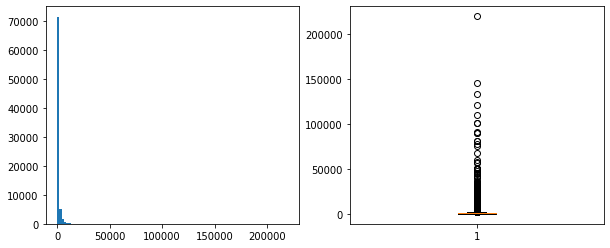

In [18]:
# O target é extremamente assimétrico

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(y_train, bins=100)

plt.subplot(1,2,2)
plt.boxplot(y_train)

plt.show()

In [19]:
y_train.describe()

count     80000.000000
mean       1098.857387
std        2491.444151
min           5.000000
25%         288.750000
50%         515.000000
75%        1100.000000
max      219600.000000
Name: rendimento, dtype: float64

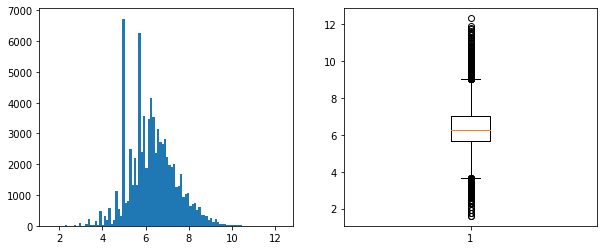

In [21]:
# O target é extremamente assimétrico

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(np.log(y_train), bins=100)

plt.subplot(1,2,2)
plt.boxplot(np.log(y_train))

plt.show()

### sigla_uf

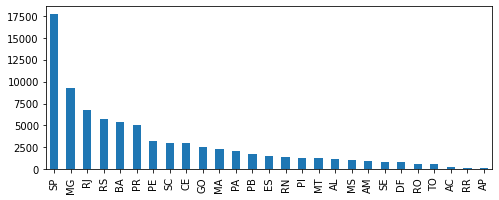

In [22]:
plt.figure(figsize=(8,3))
X_train['sigla_uf'].value_counts().plot(kind='bar')
plt.show()

In [23]:
# Plotar mapa com renda

# !pip3 install geopandas geobr descartes

import geopandas as gpd
import geobr

# Checa lista de atributos

# geobr.list_geobr()

/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  aout[:] = out
/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: Iteratio

/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  aout[:] = out
/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: Iteratio

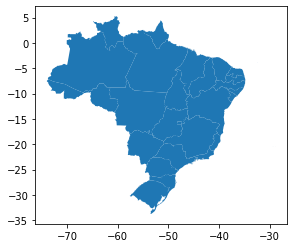

In [24]:
# Plot dos estados
estados = geobr.read_state(year=2000)
estados.plot()
plt.show()

In [25]:
X_train.join(y_train)

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
68111,RS,urbano,casa,proprio pago,7,3,1,1,1,1,...,2,2,1,0,4,1,4,2,2,502
44812,MG,urbano,casa,proprio pagando,6,3,1,1,1,1,...,1,2,0,0,5,1,5,4,1,1769
76085,RS,urbano,casa,proprio pago,6,3,1,1,1,1,...,2,2,1,1,4,1,4,2,2,13000
37522,MG,urbano,casa,proprio pago,5,1,1,2,1,2,...,2,1,0,0,1,1,1,0,1,231
11556,SP,urbano,comodo,alugado,1,1,0,1,1,1,...,2,1,0,0,1,1,1,1,0,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95786,SP,urbano,casa,proprio pago,5,1,1,1,1,1,...,2,1,0,0,1,1,1,1,0,600
64232,RJ,urbano,apartamento,proprio pago,6,2,2,1,1,1,...,2,2,1,1,3,1,3,2,1,1200
98458,RJ,urbano,casa,proprio pago,4,1,1,1,1,1,...,2,1,0,0,4,1,4,1,3,800
47856,BA,urbano,casa,proprio pago,7,2,1,1,1,1,...,2,1,1,0,3,1,3,1,2,591


In [26]:
X_train.join(y_train)[['sigla_uf', 'rendimento']].groupby('sigla_uf').median().sort_values(by='rendimento', ascending=False)

,rendimento
sigla_uf,
DF,1000.0
SP,830.0
RJ,755.0
SC,670.0
RS,600.0
AP,570.0
PR,551.0
MT,530.0
ES,529.0


### situacao_domicilio

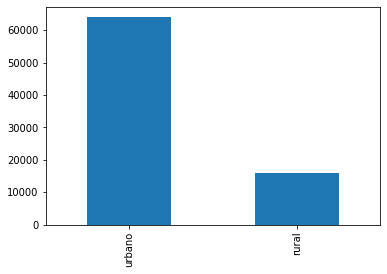

In [27]:
X_train['situacao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [28]:
X_train.join(y_train).groupby('situacao_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,videocassete,maquina_lavar,microondas,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
situacao_domicilio,,,,,,,,,,,,,,,,,,,,,
urbano,5.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,4.0,1.0,4.0,2.0,2.0,601.0
rural,5.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,4.0,3.0,4.0,2.0,2.0,300.0


### condicao_domicilio

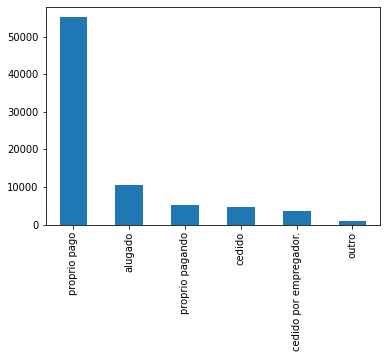

In [29]:
X_train['condicao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [30]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres
68111,RS,urbano,casa,proprio pago,7,3,1,1,1,1,...,2,2,2,1,0,4,1,4,2,2
44812,MG,urbano,casa,proprio pagando,6,3,1,1,1,1,...,1,1,2,0,0,5,1,5,4,1
76085,RS,urbano,casa,proprio pago,6,3,1,1,1,1,...,1,2,2,1,1,4,1,4,2,2
37522,MG,urbano,casa,proprio pago,5,1,1,2,1,2,...,2,2,1,0,0,1,1,1,0,1
11556,SP,urbano,comodo,alugado,1,1,0,1,1,1,...,2,2,1,0,0,1,1,1,1,0


### tipo_domicilio

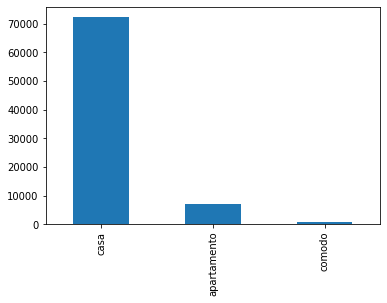

In [31]:
X_train['tipo_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [32]:
X_train.join(y_train).groupby('tipo_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,videocassete,maquina_lavar,microondas,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
tipo_domicilio,,,,,,,,,,,,,,,,,,,,,
apartamento,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,1.0,0.0,3.0,1.0,3.0,1.0,1.0,1770.0
casa,5.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,4.0,1.0,4.0,2.0,2.0,490.0
comodo,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,1.0,300.0


### comodos

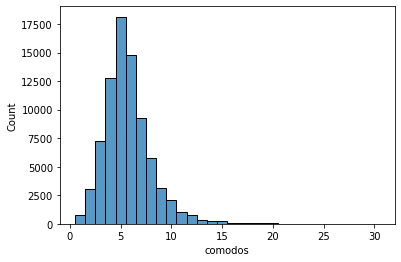

In [33]:
sns.histplot(data=X_train, x='comodos', discrete=True);

In [34]:
X_train['comodos'].describe()

count    80000.000000
mean         5.725388
std          2.374410
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         30.000000
Name: comodos, dtype: float64

## Correlações

rendimento            1.000000
banheiros             0.421114
automoveis            0.415246
televisores           0.362419
comodos               0.349248
ar_condicionado       0.299683
dormitorios           0.156450
iluminacao_publica    0.012976
moradores             0.012976
mulheres              0.012694
homens                0.007799
iluminacao           -0.082571
radio                -0.091818
agua                 -0.118308
coleta_lixo          -0.138057
geladeira            -0.148042
maquina_lavar        -0.290562
videocassete         -0.293941
telefone             -0.296532
microondas           -0.326337
computador           -0.355505
Name: rendimento, dtype: float64


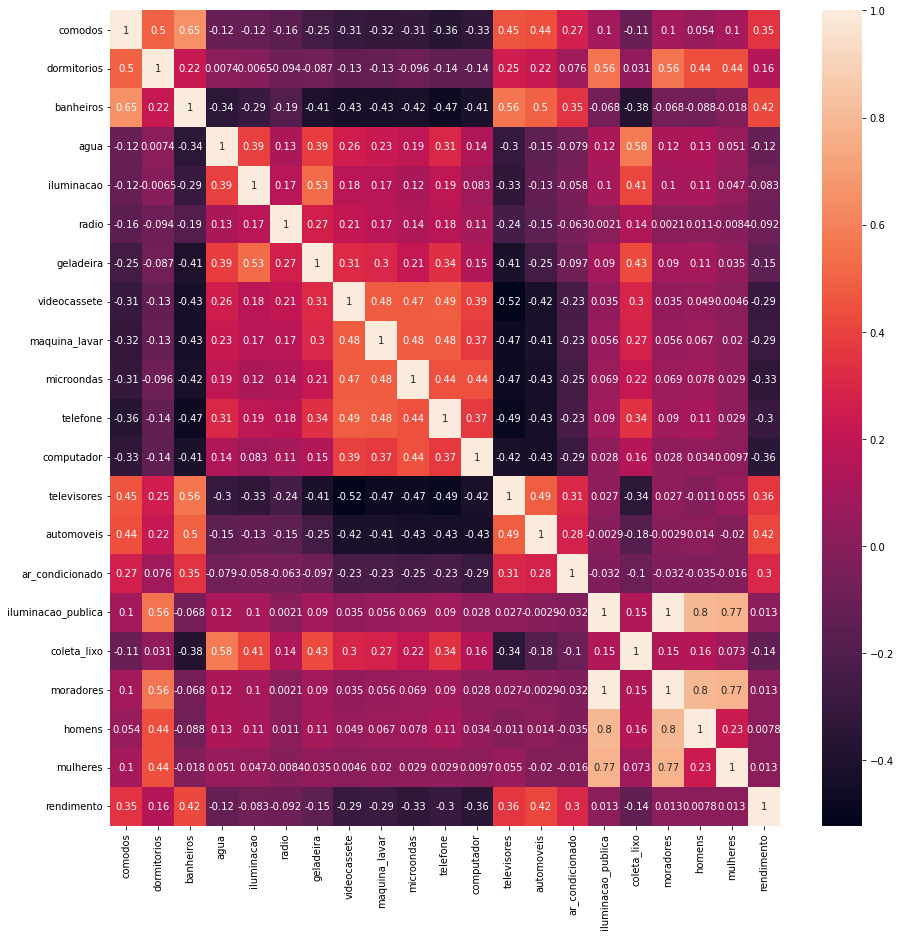

In [35]:
corr = X_train.join(y_train).corr()

plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True);

print(corr['rendimento'].sort_values(ascending=False))

## Baseline

In [36]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres
68111,RS,urbano,casa,proprio pago,7,3,1,1,1,1,...,2,2,2,1,0,4,1,4,2,2
44812,MG,urbano,casa,proprio pagando,6,3,1,1,1,1,...,1,1,2,0,0,5,1,5,4,1
76085,RS,urbano,casa,proprio pago,6,3,1,1,1,1,...,1,2,2,1,1,4,1,4,2,2
37522,MG,urbano,casa,proprio pago,5,1,1,2,1,2,...,2,2,1,0,0,1,1,1,0,1
11556,SP,urbano,comodo,alugado,1,1,0,1,1,1,...,2,2,1,0,0,1,1,1,1,0


In [37]:
# Tratamento

ohe = OneHotEncoder(drop='first')
ohe_ct = ColumnTransformer(transformers=[('ohe', ohe, [0,1,2,3])], remainder='passthrough')
std_scaler = StandardScaler()
tr_pipeline = Pipeline([('ohe_ct', ohe_ct), ('scale', std_scaler)])

tr_pipeline

Pipeline(steps=[('ohe_ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  [0, 1, 2, 3])])),
                ('scale', StandardScaler())])

In [38]:
X_train_tr = tr_pipeline.fit_transform(X_train)
X_val_tr = tr_pipeline.transform(X_val)

In [68]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42,
                                  n_jobs=-1)

forest_reg.fit(X_train_tr, y_train)
y_pred = forest_reg.predict(X_val_tr)

np.sqrt(mean_squared_error(y_val, y_pred))

1973.1987246135177

## Análises do erro

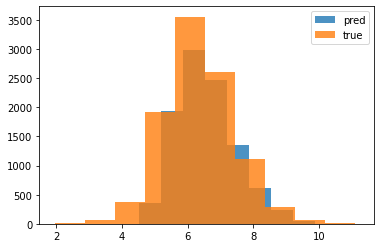

In [92]:
plt.hist(np.log(y_pred),alpha=0.8, label='pred')
plt.hist(np.log(y_val),alpha=0.8, label='true')
plt.legend()
plt.show()

In [94]:
pd.Series(y_pred).describe()

count    10000.000000
mean      1134.574542
std       1825.930327
min         90.460000
25%        362.788417
50%        630.575179
75%       1218.039792
max      74298.870000
dtype: float64

In [95]:
y_train.describe()

count     80000.000000
mean       1098.857387
std        2491.444151
min           5.000000
25%         288.750000
50%         515.000000
75%        1100.000000
max      219600.000000
Name: rendimento, dtype: float64

# Tratamento dos dados

## Tratamento de outliers

In [145]:
# Método tradicional

y_train_tr = y_train.copy()

Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)

iqr = Q3 - Q1

upper_bound = iqr + (1.5 * iqr)
lower_bound = iqr - (1.5 * iqr)

y_train_tr.loc[y_train > upper_bound] = upper_bound
y_train_tr.loc[y_train < lower_bound] = lower_bound

forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_tr)

print('RMSE: ,' np.sqrt(mean_squared_error(y_val, np.exp(y_pred))))

1890.4785878541818

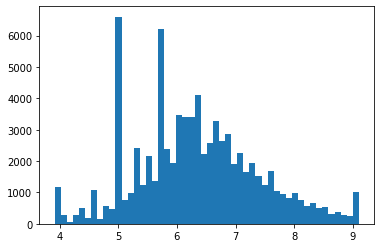

In [227]:
# Método alternativo

y_train_tr = y_train.copy()

upper_bound = np.percentile(y_train_tr, 99)
lower_bound = np.percentile(y_train_tr, 1)

y_train_tr.loc[y_train > upper_bound] = upper_bound
y_train_tr.loc[y_train < lower_bound] = lower_bound

plt.hist(np.log(y_train_tr), bins=50)
plt.show()

In [153]:
forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_tr)

np.sqrt(mean_squared_error(y_val, np.exp(y_pred)))

1660.1011618429998

In [156]:
pd.Series(np.exp(y_pred)).describe()

count    10000.000000
mean       842.727953
std        978.075088
min         75.257229
25%        294.254292
50%        512.641658
75%        955.579786
max       8476.242914
dtype: float64

In [157]:
y_train.describe()

count     80000.000000
mean       1098.857387
std        2491.444151
min           5.000000
25%         288.750000
50%         515.000000
75%        1100.000000
max      219600.000000
Name: rendimento, dtype: float64

## Feature engineering

In [169]:
X_train_feature = X_train.copy()
X_val_feature = X_val.copy()

In [172]:
X_train_feature['moradores_por_comodo'] = X_train['moradores'] / X_train['comodos']
X_train_feature['moradores_por_dormitorio'] = X_train['moradores'] / X_train['dormitorios']

X_val_feature['moradores_por_comodo'] = X_val['moradores'] / X_val['comodos']
X_val_feature['moradores_por_dormitorio'] = X_val['moradores'] / X_val['dormitorios']

In [173]:
X_train_feature_tr = tr_pipeline.fit_transform(X_train_feature)
X_val_feature_tr = tr_pipeline.transform(X_val_feature)

In [175]:
forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_feature_tr)

np.sqrt(mean_squared_error(y_val, np.exp(y_pred)))

1663.5571300900015

# Treinando modelos

In [235]:
forest_reg = RandomForestRegressor(n_estimators=200,
                                   random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_feature_tr)

print('RMSE: ', np.sqrt(mean_squared_error(y_val, np.exp(y_pred))))

RMSE:  1664.148504309361


In [182]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_estimators=1000,
                       learning_rate=0.02,
                       n_jobs=-1,
                       random_state=42)

xgb_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = xgb_reg.predict(X_val_feature_tr)

print('RMSE: ', np.sqrt(mean_squared_error(y_val, np.exp(y_pred))))

RMSE:  1633.107952790717


In [230]:
# LGBM

# !pip install lightgbm

from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(n_estimators=500, 
                         learning_rate=0.05,
                         min_child_samples=50,
                         n_jobs=-1, 
                         random_state=42)

lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = lgbm_reg.predict(X_val_feature_tr)

print('RMSE: ', np.sqrt(mean_squared_error(y_val, np.exp(y_pred))))

RMSE:  1635.1203069614583


In [238]:
# LGBM

# !pip install lightgbm

from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(n_jobs=-1, 
                         random_state=42)

lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = lgbm_reg.predict(X_val_feature_tr)

print('RMSE: ', np.sqrt(mean_squared_error(y_val, np.exp(y_pred))))

RMSE:  1637.4976145807013


In [237]:
from sklearn.metrics import mean_absolute_error

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  546.5522087718854
